In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.svm import LinearSVC


In [30]:
%matplotlib inline
someStopWords = text.ENGLISH_STOP_WORDS.difference(['off', 'all',
                                                    'because',
                                                    'been',
                                                    'every',
                                                    'for',
                                                    'get',
                                                    'give',
                                                    'her',
                                                    'hers',
                                                    'his',
                                                    'made',
                                                    'me',
                                                    'move',
                                                    'my',
                                                    'never',
                                                    'no',
                                                    'not',
                                                    'nowhere',
                                                    'off',
                                                    'put',
                                                    'see',
                                                    'should',
                                                    'some',
                                                    'someone',
                                                    'then',
                                                    'under',
                                                    'when',
                                                    'why',
                                                    'you',
                                                    'your',
                                                    'yours',
                                                    'yourself',
                                                    'yourselves',
                                                    'ma',
                                                    ])

In [34]:

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        filtered_final.reset_index(drop=True, inplace=True)
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
    
        #count = CountVectorizer(alternate_sign=False, stop_words='english', analyzer='char_wb', ngram_range=(5,5))
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, stop_words='english', analyzer='char_wb', ngram_range=(5,5), binary=True, strip_accents='unicode')

        uidArray = self.grouped_by_productid.UserId
        userFeatures = hv.fit_transform(uidArray, someStopWords)

        return userFeatures
    
   
        
        

In [22]:


class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

In [35]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('/Users/marcinia/Downloads/Amazon.csv', 4)

/Users/marcinia/Downloads/Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as picture

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (10,) and (54,)

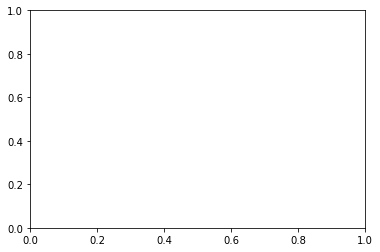

In [36]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 55):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 55), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [25]:
# fit KMeans with  clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20, n_init=15, init='k-means++', algorithm="elkan", max_iter=300)

km.fit(amazonData.X)

KMeans(algorithm='elkan', n_clusters=56, n_init=25)

In [26]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km)

In [ ]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(10)

--------------------------------------------------
cluster:  1
cluster size:  (1399, 4)
         ProductId  cluster                                     Summary  \
123045  B000Y041JW        1                   Savu Smoker bag for grill   
222219  B0029NMENM        1  Great dog food and EXCELLENT SERVICE!!!!!!   
39249   B000E4C2LW        1                   Nature's Path Corn Flakes   
175541  B001EO6BFE        1      Kids say these are better than mine :(   
107071  B000QV2GNW        1                           Great tasting bar   
260831  B0038B1DEU        1                      Great in veggie shakes   
63220   B000FK63SS        1                           Fantastic lasagne   
144236  B0018KNGDY        1                         Great Chocolate Bar   
260651  B00384GGLC        1                     don't like taste at all   
14699   B0002XIBO2        1                           Old Time Favorite   

                                                     Text  
123045  Great purchase -- 

Attempt at recommending 😂


In [ ]:
#I'm not very good at coding 

def predict(str_0):
    P = vectorizer.transform(list(str_0))
    prediction = model.predict(P)
    return prediction